In [1]:
import pandas as pd
import numpy as np
import ast

In [2]:
file_path = 'UoB_Set01_2025-01-02LOBs.txt'

In [3]:
# Parsing single-line text
def parse_line_corrected(line):
    line = line.replace('Exch0', "'Exch0'")
    data = ast.literal_eval(line)
    return {
        'timestamp': data[0],
        'exchange': data[1],
        'bids': data[2][0][1],
        'asks': data[2][1][1]
    }

In [4]:
# Parses incoming text line by line
parsed_data_corrected = []
with open(file_path, 'r') as file:
    for line in file:
        parsed_data_corrected.append(parse_line_corrected(line))

In [5]:
df_corrected = pd.DataFrame(parsed_data_corrected)

In [6]:
df_corrected = df_corrected[['exchange', 'timestamp', 'bids', 'asks']]
df_corrected.head()

,exchange,timestamp,bids,asks
0,Exch0,0.000,[],[]
1,Exch0,0.279,"[[1, 6]]",[]
2,Exch0,1.333,"[[1, 6]]","[[800, 1]]"
3,Exch0,1.581,"[[1, 6]]","[[799, 1]]"
4,Exch0,1.643,"[[1, 6]]","[[798, 1]]"


In [7]:
# Sort bids and asks and take the top two
def process_row(row):
    bids_sorted = sorted(row['bids'], key=lambda x: x[0], reverse=True)[:2] if row['bids'] else []
    asks_sorted = sorted(row['asks'], key=lambda x: x[0])[:2] if row['asks'] else []
    return bids_sorted, asks_sorted

In [8]:
df_corrected[['bids', 'asks']] = df_corrected.apply(lambda row: process_row(row), axis=1, result_type='expand')
df_filtered = (df_corrected[(df_corrected['bids'].apply(len) >= 2) & (df_corrected['asks'].apply(len) >= 2)]).reset_index(drop=True)
df_filtered.head()

,exchange,timestamp,bids,asks
0,Exch0,2.015,"[[261, 1], [1, 6]]","[[338, 3], [797, 1]]"
1,Exch0,2.139,"[[261, 1], [1, 6]]","[[297, 5], [338, 3]]"
2,Exch0,2.697,"[[262, 6], [261, 1]]","[[297, 5], [338, 3]]"
3,Exch0,3.069,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
4,Exch0,3.131,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"


In [9]:
def remove_max_bid_outliers(bids, mean_price, std_price, threshold=3):
    if not bids:
        return True  
    # Calculate z-score for the maximum bid price
    max_bid_price = max(bid[0] for bid in bids)
    z_score = abs(max_bid_price - mean_price) / std_price
    
    # Return True if the z-score is within the threshold, indicating it's not an outlier
    return z_score <= threshold

# Calculate the mean and standard deviation for the maximum bid prices
max_bid_prices = [max(bid[0] for bid in bids_list) for bids_list in df_filtered['bids'] if bids_list]
mean_max_price = np.mean(max_bid_prices)
std_max_price = np.std(max_bid_prices)

# Filter the DataFrame rows
df_filtered_no_max_outliers = df_filtered[df_filtered['bids'].apply(
    lambda bids: remove_max_bid_outliers(bids, mean_max_price, std_max_price, 3)
)]

# Reset the index after the filter operation
df_filtered_no_max_outliers = df_filtered_no_max_outliers.reset_index(drop=True)

df_filtered_no_max_outliers

,exchange,timestamp,bids,asks
0,Exch0,2.015,"[[261, 1], [1, 6]]","[[338, 3], [797, 1]]"
1,Exch0,2.139,"[[261, 1], [1, 6]]","[[297, 5], [338, 3]]"
2,Exch0,2.697,"[[262, 6], [261, 1]]","[[297, 5], [338, 3]]"
3,Exch0,3.069,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
4,Exch0,3.131,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
...,...,...,...,...
350581,Exch0,30599.542,"[[290, 1], [288, 2]]","[[294, 1], [401, 5]]"
350582,Exch0,30599.573,"[[290, 1], [288, 2]]","[[294, 1], [401, 5]]"
350583,Exch0,30599.635,"[[290, 1], [288, 2]]","[[294, 1], [397, 5]]"
350584,Exch0,30599.759,"[[288, 1], [281, 4]]","[[294, 1], [397, 5]]"


In [10]:
def remove_min_bid_outliers(bids, mean_min_price, std_min_price, threshold=3):
    if not bids:
        return True
    min_bid_price = min(bid[0] for bid in bids)
    z_score = (min_bid_price - mean_min_price) / std_min_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for the minimum bid prices across the DataFrame
min_bid_prices = [min(bid[0] for bid in bids_list) for bids_list in df_filtered_no_max_outliers['bids'] if bids_list]
mean_min_price = np.mean(min_bid_prices)
std_min_price = np.std(min_bid_prices)

# Apply the outlier removal function to each row
df_filtered_no_min_outliers = df_filtered_no_max_outliers[df_filtered_no_max_outliers['bids'].apply(
    lambda bids: remove_min_bid_outliers(bids, mean_min_price, std_min_price, 3)
)]

# Reset index
df_filtered_no_min_outliers.reset_index(drop=True, inplace=True)

# Display the first few rows
df_filtered_no_min_outliers

,exchange,timestamp,bids,asks
0,Exch0,2.697,"[[262, 6], [261, 1]]","[[297, 5], [338, 3]]"
1,Exch0,3.069,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
2,Exch0,3.131,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
3,Exch0,3.255,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
4,Exch0,3.286,"[[262, 6], [261, 1]]","[[292, 5], [296, 1]]"
...,...,...,...,...
346594,Exch0,30599.542,"[[290, 1], [288, 2]]","[[294, 1], [401, 5]]"
346595,Exch0,30599.573,"[[290, 1], [288, 2]]","[[294, 1], [401, 5]]"
346596,Exch0,30599.635,"[[290, 1], [288, 2]]","[[294, 1], [397, 5]]"
346597,Exch0,30599.759,"[[288, 1], [281, 4]]","[[294, 1], [397, 5]]"


In [11]:
def remove_min_ask_outliers(asks, mean_price, std_price, threshold=3):
    if not asks:
        return True  # Keep rows with no asks as they're not outliers
    min_ask_price = min(ask[0] for ask in asks)
    z_score = (min_ask_price - mean_price) / std_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for minimum ask prices
min_ask_prices = [min(ask[0] for ask in asks_list) for asks_list in df_filtered['asks'] if asks_list]
mean_min_ask_price = np.mean(min_ask_prices)
std_min_ask_price = np.std(min_ask_prices)

# Apply the function to filter rows based on minimum ask price outliers
df_filtered_no_min_ask_outliers = df_filtered_no_min_outliers[df_filtered_no_min_outliers['asks'].apply(
    lambda asks: remove_min_ask_outliers(asks, mean_min_ask_price, std_min_ask_price, 3)
)]

# Reset the index after filtering
df_filtered_no_min_ask_outliers.reset_index(drop=True, inplace=True)

df_filtered_no_min_ask_outliers

,exchange,timestamp,bids,asks
0,Exch0,2.697,"[[262, 6], [261, 1]]","[[297, 5], [338, 3]]"
1,Exch0,3.069,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
2,Exch0,3.131,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
3,Exch0,3.255,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
4,Exch0,3.286,"[[262, 6], [261, 1]]","[[292, 5], [296, 1]]"
...,...,...,...,...
340203,Exch0,30599.542,"[[290, 1], [288, 2]]","[[294, 1], [401, 5]]"
340204,Exch0,30599.573,"[[290, 1], [288, 2]]","[[294, 1], [401, 5]]"
340205,Exch0,30599.635,"[[290, 1], [288, 2]]","[[294, 1], [397, 5]]"
340206,Exch0,30599.759,"[[288, 1], [281, 4]]","[[294, 1], [397, 5]]"


In [12]:
def remove_max_ask_outlier(asks, mean_price, std_price, threshold=3):
    if not asks:
        return True
    max_ask_price = max(ask[0] for ask in asks)
    z_score = (max_ask_price - mean_price) / std_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for maximum ask prices
max_ask_prices = [max(ask[0] for ask in asks_list) for asks_list in df_filtered_no_min_ask_outliers['asks'] if asks_list]
mean_max_ask_price = np.mean(max_ask_prices)
std_max_ask_price = np.std(max_ask_prices)

# Apply the function to filter rows based on maximum ask price outliers
df_filtered_no_max_ask_outliers = df_filtered_no_min_ask_outliers[df_filtered_no_min_ask_outliers['asks'].apply(
    lambda asks: remove_max_ask_outlier(asks, mean_max_ask_price, std_max_ask_price, 3)
)]

# Reset the index after filtering
df_filtered_no_max_ask_outliers.reset_index(drop=True, inplace=True)

df_filtered_no_max_ask_outliers

,exchange,timestamp,bids,asks
0,Exch0,2.697,"[[262, 6], [261, 1]]","[[297, 5], [338, 3]]"
1,Exch0,3.069,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
2,Exch0,3.131,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
3,Exch0,3.255,"[[262, 6], [261, 1]]","[[296, 1], [297, 5]]"
4,Exch0,3.286,"[[262, 6], [261, 1]]","[[292, 5], [296, 1]]"
...,...,...,...,...
329941,Exch0,30599.542,"[[290, 1], [288, 2]]","[[294, 1], [401, 5]]"
329942,Exch0,30599.573,"[[290, 1], [288, 2]]","[[294, 1], [401, 5]]"
329943,Exch0,30599.635,"[[290, 1], [288, 2]]","[[294, 1], [397, 5]]"
329944,Exch0,30599.759,"[[288, 1], [281, 4]]","[[294, 1], [397, 5]]"


In [13]:
def split_bids_asks(row):
    # Splitting bids into prices and sizes
    bid_price1, bid_size1 = row['bids'][0]
    bid_price2, bid_size2 = row['bids'][1]
    ask_price1, ask_size1 = row['asks'][0]
    ask_price2, ask_size2 = row['asks'][1]  
    return pd.Series([bid_price1, bid_price2, bid_size1, bid_size2, ask_price1, ask_price2, ask_size1, ask_size2])

# Apply the function to each row of the DataFrame and create new columns
df_final_filtered = df_filtered_no_max_ask_outliers.copy()
df_final_filtered[['bid_price1', 'bid_price2', 'bid_size1', 'bid_size2', 'ask_price1', 'ask_price2', 'ask_size1', 'ask_size2']] = df_final_filtered.apply(split_bids_asks, axis=1)
df_final_filtered.drop(['bids', 'asks'], axis=1, inplace=True)

# Display the first few rows of the DataFrame to verify the changes
df_final_filtered

,exchange,timestamp,bid_price1,bid_price2,bid_size1,bid_size2,ask_price1,ask_price2,ask_size1,ask_size2
0,Exch0,2.697,262,261,6,1,297,338,5,3
1,Exch0,3.069,262,261,6,1,296,297,1,5
2,Exch0,3.131,262,261,6,1,296,297,1,5
3,Exch0,3.255,262,261,6,1,296,297,1,5
4,Exch0,3.286,262,261,6,1,292,296,5,1
...,...,...,...,...,...,...,...,...,...,...
329941,Exch0,30599.542,290,288,1,2,294,401,1,5
329942,Exch0,30599.573,290,288,1,2,294,401,1,5
329943,Exch0,30599.635,290,288,1,2,294,397,1,5
329944,Exch0,30599.759,288,281,1,4,294,397,1,5


In [14]:
# Convert 'timestamp' to a datetime index (assuming timestamps are already in a proper format or sequence)
df_final_filtered['timestamp'] = pd.to_datetime(df_final_filtered['timestamp'], unit='s')
df_final_filtered.set_index('timestamp', inplace=True)

In [15]:
df_final_filtered

,exchange,bid_price1,bid_price2,bid_size1,bid_size2,ask_price1,ask_price2,ask_size1,ask_size2
timestamp,,,,,,,,,
1970-01-01 00:00:02.697,Exch0,262,261,6,1,297,338,5,3
1970-01-01 00:00:03.069,Exch0,262,261,6,1,296,297,1,5
1970-01-01 00:00:03.131,Exch0,262,261,6,1,296,297,1,5
1970-01-01 00:00:03.255,Exch0,262,261,6,1,296,297,1,5
1970-01-01 00:00:03.286,Exch0,262,261,6,1,292,296,5,1
...,...,...,...,...,...,...,...,...,...
1970-01-01 08:29:59.542,Exch0,290,288,1,2,294,401,1,5
1970-01-01 08:29:59.573,Exch0,290,288,1,2,294,401,1,5
1970-01-01 08:29:59.635,Exch0,290,288,1,2,294,397,1,5


In [16]:
from statsmodels.tsa.stattools import adfuller

# Extract the 'lowest_ask' column for stationarity testing
highest_bid_series = df_final_filtered['bid_price1']

# Perform Augmented Dickey-Fuller test
result = adfuller(highest_bid_series.dropna(), autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Using Critical Values for decision
is_stationary = True
for key, value in result[4].items():
    if result[0] > value:
        is_stationary = False
        break

if is_stationary:
    print("The series is stationary based on critical values.")
else:
    print("The series is not stationary based on critical values.")

ADF Statistic: -12.385600
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
The series is stationary based on critical values.


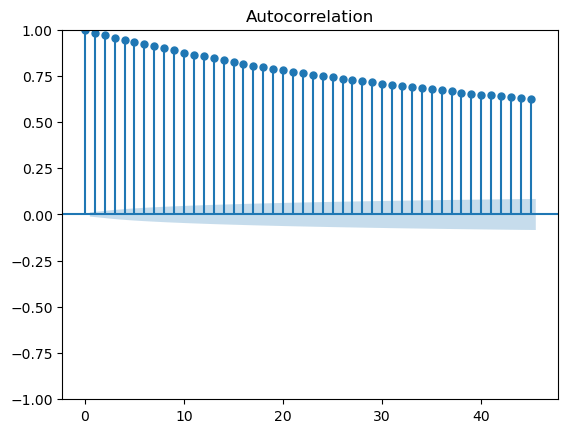

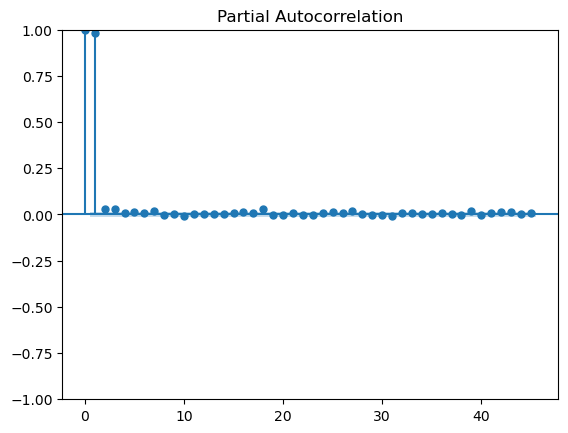

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Selecting the first 2000 rows
data_subset = df_final_filtered['bid_price1'].iloc[:30000]

# Plot ACF and PACF for the subset
plot_acf(data_subset)
plot_pacf(data_subset)
plt.show()

In [19]:
import pmdarima as pm

# Assuming you have your time series data in 'lowest_ask_series'
# auto_arima scans various combinations of p, d, and q to find the best ARIMA model
best_model = pm.auto_arima(data_subset, seasonal=False, stepwise=True,
                           suppress_warnings=True, D=1, max_p=5, max_q=5, max_d=2,
                           error_action='ignore', trace=True)

print(f"Best ARIMA order: {best_model.order}")
print(f"Best seasonal order: {best_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=27.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=91552.058, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91509.331, Time=1.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=91505.712, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91550.060, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=30.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=91464.253, Time=2.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=27.51 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=91457.562, Time=3.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=43.29 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=91448.611, Time=4.81 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=42.35 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=91442.719, Time=5.22 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=52.33 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=91440.7

In [20]:
# Splitting data into training and test sets
split_point = int(len(data_subset) * 0.8)
train, test = data_subset[:split_point], data_subset[split_point:]

In [21]:
import warnings

warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.")
warnings.filterwarnings("ignore", message="No supported index is available. Prediction results will be given with an integer index beginning at `start`.")
warnings.filterwarnings("ignore", message="No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")

In [35]:
from statsmodels.tsa.arima.model import ARIMA

update_frequency = 5
history = train.copy()
predictions = [None] * len(test)
window_size = 100  # Adjust the window size as needed

for t in range(0, len(test), update_frequency):
    # Use a rolling window to fit the model on a subset of the history
    start_idx = max(0, len(history) - window_size)
    model = ARIMA(history.iloc[start_idx:], order=(1, 1, 1))
    model_fit = model.fit()

    # Make predictions for the next 5 steps
    next_steps_predictions = model_fit.forecast(steps=update_frequency)

    # Store the predictions
    if t + update_frequency < len(test):
        predictions[t:t + update_frequency] = next_steps_predictions
    else:
        predictions[t:] = next_steps_predictions[:len(test) - t]

    # Update the history with the new observations
    if t + update_frequency < len(test):
        new_history = test[t:t + update_frequency]
        history = pd.concat([history, new_history])

    print(t)

predictions_series = pd.Series(predictions, index=test.index)



0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220
1225
1230
1235
1240
1245
1250
1255
1260
1265
1270
1275
1280
1285
1290
1295
1300
1305
1310
1315
1320
1325
1330
1335
1340
1345
1350
1355
1360
1365
1370
1375
1380
1385
1390
1395
1400
1405
1410
1415


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



1420
1425
1430
1435
1440
1445
1450
1455
1460
1465
1470
1475
1480
1485
1490
1495
1500
1505
1510
1515
1520
1525
1530
1535
1540
1545
1550
1555
1560
1565
1570
1575
1580
1585
1590
1595
1600
1605
1610
1615
1620
1625
1630
1635
1640
1645
1650
1655
1660
1665
1670
1675
1680
1685
1690
1695
1700
1705
1710
1715
1720
1725
1730
1735
1740
1745
1750
1755
1760
1765
1770
1775
1780
1785
1790
1795
1800
1805
1810
1815
1820
1825
1830
1835
1840
1845
1850
1855
1860
1865
1870
1875
1880
1885
1890
1895
1900
1905
1910
1915
1920
1925
1930
1935
1940
1945
1950
1955
1960
1965
1970
1975
1980
1985
1990
1995
2000
2005
2010
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
2100
2105
2110
2115
2120
2125
2130
2135
2140
2145
2150
2155
2160
2165
2170
2175
2180
2185
2190
2195
2200
2205
2210
2215
2220
2225
2230
2235
2240
2245
2250
2255


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



2260
2265


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



2270
2275
2280
2285
2290
2295
2300
2305
2310
2315
2320
2325
2330
2335
2340
2345
2350
2355
2360
2365
2370
2375
2380
2385
2390
2395
2400
2405
2410
2415
2420
2425
2430
2435
2440
2445
2450
2455
2460
2465
2470
2475
2480
2485
2490
2495
2500
2505
2510
2515
2520
2525
2530
2535
2540
2545
2550
2555
2560
2565
2570
2575
2580
2585
2590
2595
2600
2605
2610
2615
2620
2625
2630
2635
2640
2645


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



2650
2655
2660
2665


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



2670
2675
2680
2685
2690
2695
2700
2705
2710
2715
2720
2725
2730
2735
2740
2745
2750
2755
2760
2765
2770
2775
2780
2785
2790
2795
2800
2805
2810
2815
2820
2825
2830
2835
2840
2845
2850
2855
2860
2865
2870
2875
2880
2885
2890
2895
2900
2905
2910
2915
2920
2925
2930
2935
2940
2945
2950
2955
2960
2965
2970
2975
2980
2985
2990
2995
3000
3005
3010
3015
3020
3025
3030
3035
3040
3045
3050
3055
3060
3065
3070
3075
3080
3085
3090
3095
3100
3105
3110
3115
3120
3125
3130
3135
3140
3145
3150
3155
3160
3165
3170
3175
3180
3185
3190
3195
3200
3205
3210
3215
3220
3225
3230
3235
3240
3245
3250
3255
3260
3265
3270
3275
3280
3285
3290
3295
3300
3305
3310
3315
3320
3325
3330
3335
3340
3345
3350
3355
3360
3365
3370
3375
3380
3385
3390
3395
3400
3405
3410
3415
3420
3425
3430


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



3435
3440
3445
3450
3455
3460
3465
3470
3475
3480
3485
3490
3495
3500
3505
3510
3515
3520
3525
3530
3535
3540
3545
3550
3555
3560
3565
3570
3575
3580
3585
3590
3595
3600
3605
3610
3615
3620
3625
3630
3635
3640
3645
3650
3655
3660
3665
3670
3675
3680
3685
3690
3695
3700
3705
3710
3715
3720
3725
3730
3735
3740
3745
3750
3755
3760
3765
3770
3775
3780
3785
3790
3795
3800
3805
3810
3815
3820
3825
3830
3835
3840
3845
3850
3855
3860
3865
3870
3875
3880
3885
3890
3895
3900
3905
3910
3915
3920
3925
3930
3935
3940
3945
3950
3955
3960
3965
3970
3975
3980
3985
3990
3995
4000
4005
4010
4015
4020
4025
4030
4035
4040
4045
4050
4055
4060
4065
4070
4075
4080
4085
4090
4095
4100
4105
4110
4115
4120
4125
4130
4135
4140
4145
4150
4155
4160
4165
4170
4175
4180
4185
4190
4195
4200
4205
4210
4215
4220
4225
4230
4235
4240
4245
4250
4255
4260
4265
4270
4275
4280
4285
4290
4295
4300
4305
4310
4315
4320
4325
4330
4335
4340
4345
4350
4355
4360
4365
4370
4375
4380
4385
4390


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



4395
4400
4405
4410
4415


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



4420
4425
4430
4435
4440
4445
4450
4455
4460
4465
4470
4475
4480
4485
4490
4495
4500
4505
4510
4515
4520
4525
4530
4535
4540
4545
4550
4555
4560
4565
4570
4575
4580
4585
4590
4595
4600
4605
4610
4615
4620
4625
4630
4635
4640
4645
4650
4655
4660
4665
4670
4675
4680
4685
4690
4695
4700
4705
4710
4715
4720
4725
4730
4735
4740
4745
4750
4755
4760
4765
4770
4775
4780
4785
4790
4795
4800
4805
4810
4815
4820
4825
4830
4835
4840
4845
4850
4855
4860
4865
4870
4875
4880
4885
4890
4895
4900
4905
4910
4915
4920
4925
4930
4935
4940
4945
4950
4955
4960
4965
4970
4975
4980
4985
4990
4995
5000
5005
5010
5015
5020
5025
5030
5035
5040
5045
5050
5055
5060
5065
5070
5075
5080
5085
5090
5095
5100
5105
5110
5115
5120
5125
5130
5135
5140
5145
5150
5155
5160
5165
5170
5175
5180
5185
5190
5195
5200
5205
5210
5215
5220
5225
5230
5235
5240
5245
5250
5255
5260
5265
5270
5275
5280
5285
5290
5295
5300
5305
5310
5315
5320
5325
5330
5335
5340
5345
5350
5355
5360
5365
5370
5375
5380
5385
5390
5395
5400
5405
5410
5415


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



5635
5640
5645
5650
5655
5660
5665
5670
5675
5680
5685
5690
5695
5700
5705
5710
5715
5720
5725
5730
5735
5740
5745
5750
5755
5760
5765
5770
5775
5780
5785
5790
5795
5800
5805
5810
5815
5820
5825
5830
5835
5840
5845
5850
5855
5860
5865
5870


D:\anaconda\envs\text_analytics\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



5875
5880
5885
5890
5895
5900
5905
5910
5915
5920
5925
5930
5935
5940
5945
5950
5955
5960
5965
5970
5975
5980
5985
5990
5995


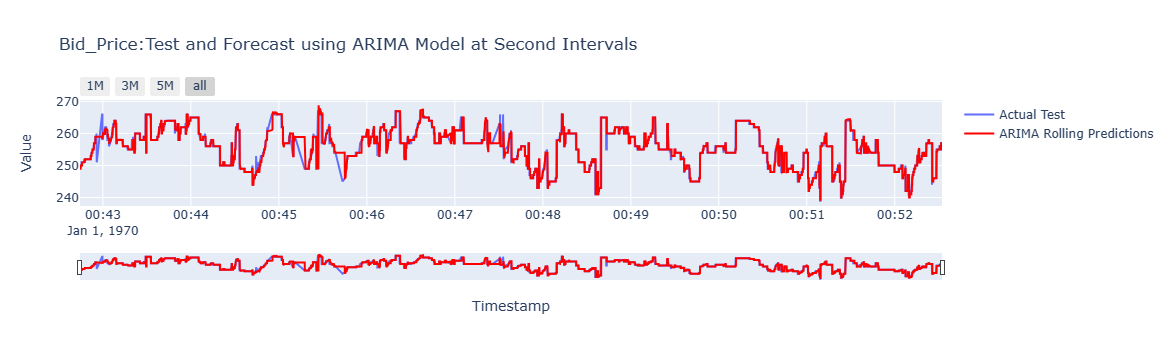

In [36]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test, mode='lines', name='Actual Test'))
fig.add_trace(go.Scatter(x=predictions_series.index, y=predictions_series, mode='lines', name='ARIMA Rolling Predictions', line=dict(color='red')))
fig.update_layout(
    title='Bid_Price:Test and Forecast using ARIMA Model at Second Intervals',
    xaxis_title='Timestamp',
    yaxis_title='Value',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1M", step="minute", stepmode="backward"),
                dict(count=3, label="3M", step="minute", stepmode="backward"),
                dict(count=5, label="5M", step="minute", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()

In [41]:
bid = pd.concat([test, predictions_series], axis=1)

In [44]:
bid.to_csv('bid.csv', index=True)

In [37]:
fig.write_html("bid_price.html")

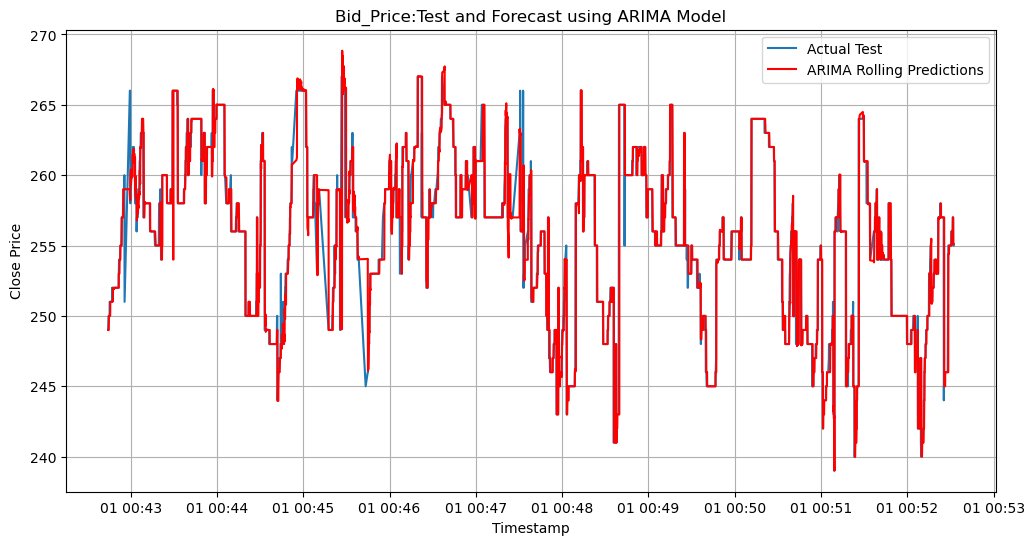

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Test')
plt.plot(predictions_series.index, predictions_series.values, label='ARIMA Rolling Predictions', color='red')
plt.title('Bid_Price:Test and Forecast using ARIMA Model')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"Root Mean Squared Error (RMSE) of Predictions: {rmse}")

Root Mean Squared Error (RMSE) of Predictions: 1.8369549289986211
